# Histogramas para diagramas de constelación

In [1]:
import sofa
import polars as pl
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import json
import os

from scipy.io import loadmat
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

from sklearn.mixture import GaussianMixture

2023-07-10 16:05:45.471470: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-10 16:05:45.479006: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-10 16:05:45.519542: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-10 16:05:45.520112: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-10 16:05:46.288435: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
# Función especial para leer todos los datos con la estructura estudiada
def read_data(folder_rx):
    data = {}

    # Leer la carpeta principal
    for folder in os.listdir(folder_rx):
        # Leer las subcarpetas
        if folder.endswith("spacing"):
            data[folder] = {}
            for file in os.listdir(f"{folder_rx}/{folder}"):
                if file.find("consY") != -1:
                    data_name = file.split("_")[2]
                    if data[folder].get(data_name) == None:
                        data[folder][data_name] = {}
                    mat_file_data = loadmat(f"{folder_rx}/{folder}/{file}")
                    data[folder][data_name] = mat_file_data
    return data

def plot_constellation_diagram(X, snr):
    plt.scatter(X.real, X.imag, alpha=0.5)
    plt.title(f"Constellation diagram for {snr[5:]}")
    plt.xlabel("I")
    plt.ylabel("Q")
    plt.grid(True)
    
    
def calculate_3d_histogram(X, bins, limits, spacing, snr):
    lower, higher = limits
    hist, xedges, yedges = np.histogram2d(X.real, X.imag, bins=bins, range=[[lower, higher], [lower, higher]])

    # Define the extent
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    # Create the meshgrid for the surface plot, excluding the last edge
    x_mesh, y_mesh = np.meshgrid(xedges[:-1], yedges[:-1])
    
    return hist, x_mesh, y_mesh
    
def plot_3d_histogram(X, bins, limits, spacing, snr, ax, histogram={}):
    hist, x_mesh, y_mesh = calculate_3d_histogram(X, bins, limits, spacing, snr)
    
    if histograms.get(f"{spacing}GHz_spacing") == None:
        histograms[f"{spacing}GHz_spacing"] = {}
    histograms[f"{spacing}GHz_spacing"][snr[5:]] = hist
    
    # Plot the 3D surface
    ax.plot_surface(x_mesh, y_mesh, hist.T, cmap="seismic", rstride=1, cstride=1, edgecolor="none")
    ax.set_xlabel("I")
    ax.set_ylabel("Q")
    ax.set_title(f"Histogram for {snr[5:]}")
    
    return histograms

def histogram_to_array(x, y):
    return np.repeat(x, y)

def plot_histogram_and_gmm(X, bins, limits, ax, gaussians):
    hist_y, hist_x = np.histogram(X.real, bins=bins)
    # Remove last bin edge
    hist_x = hist_x[:-1]
        
    array = histogram_to_array(hist_x, hist_y).reshape(-1, 1)
    
    x = np.linspace(*limits, 1000)
    gm = GaussianMixture(n_components=4).fit(array)
    logprob = gm.score_samples(x.reshape(-1, 1))
    responsibilities = gm.predict_proba(x.reshape(-1, 1))
    pdf = np.exp(logprob)
    pdf_individual = responsibilities * pdf[:, np.newaxis]
    
    if gaussians.get(f"{spacing}GHz_spacing") == None:
        gaussians[f"{spacing}GHz_spacing"] = {}
    gaussians[f"{spacing}GHz_spacing"][snr[5:]] = gm
    
    ax.hist(X.real, bins=bins, density=True, alpha=0.5)
    ax.plot(x, pdf_individual, '--')
    plt.grid(True)
    
    return gaussians

In [3]:
file_tx = "Demodulation/Data/2x16QAM_16GBd.mat"
folder_rx = "Demodulation/Data/"

# Transmitted data
X_tx_norm = loadmat(file_tx)
X_tx_norm = X_tx_norm.get("Constellation").flatten()[0][0].flatten()
X_tx = sofa.mod_norm(X_tx_norm, 10)*X_tx_norm

# Read received data
data = read_data(folder_rx)

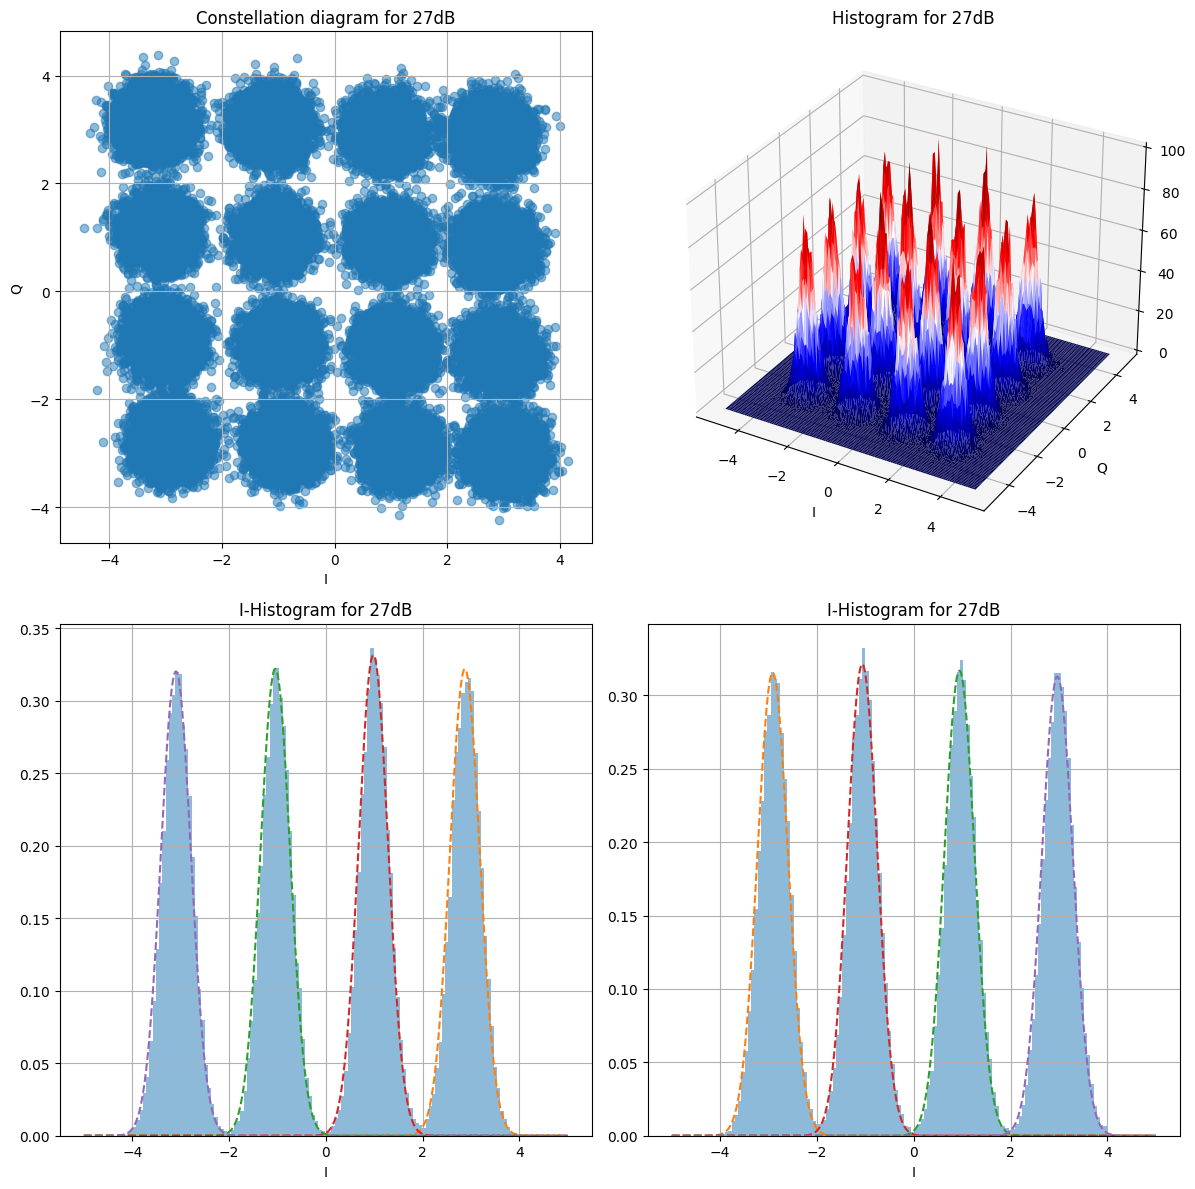

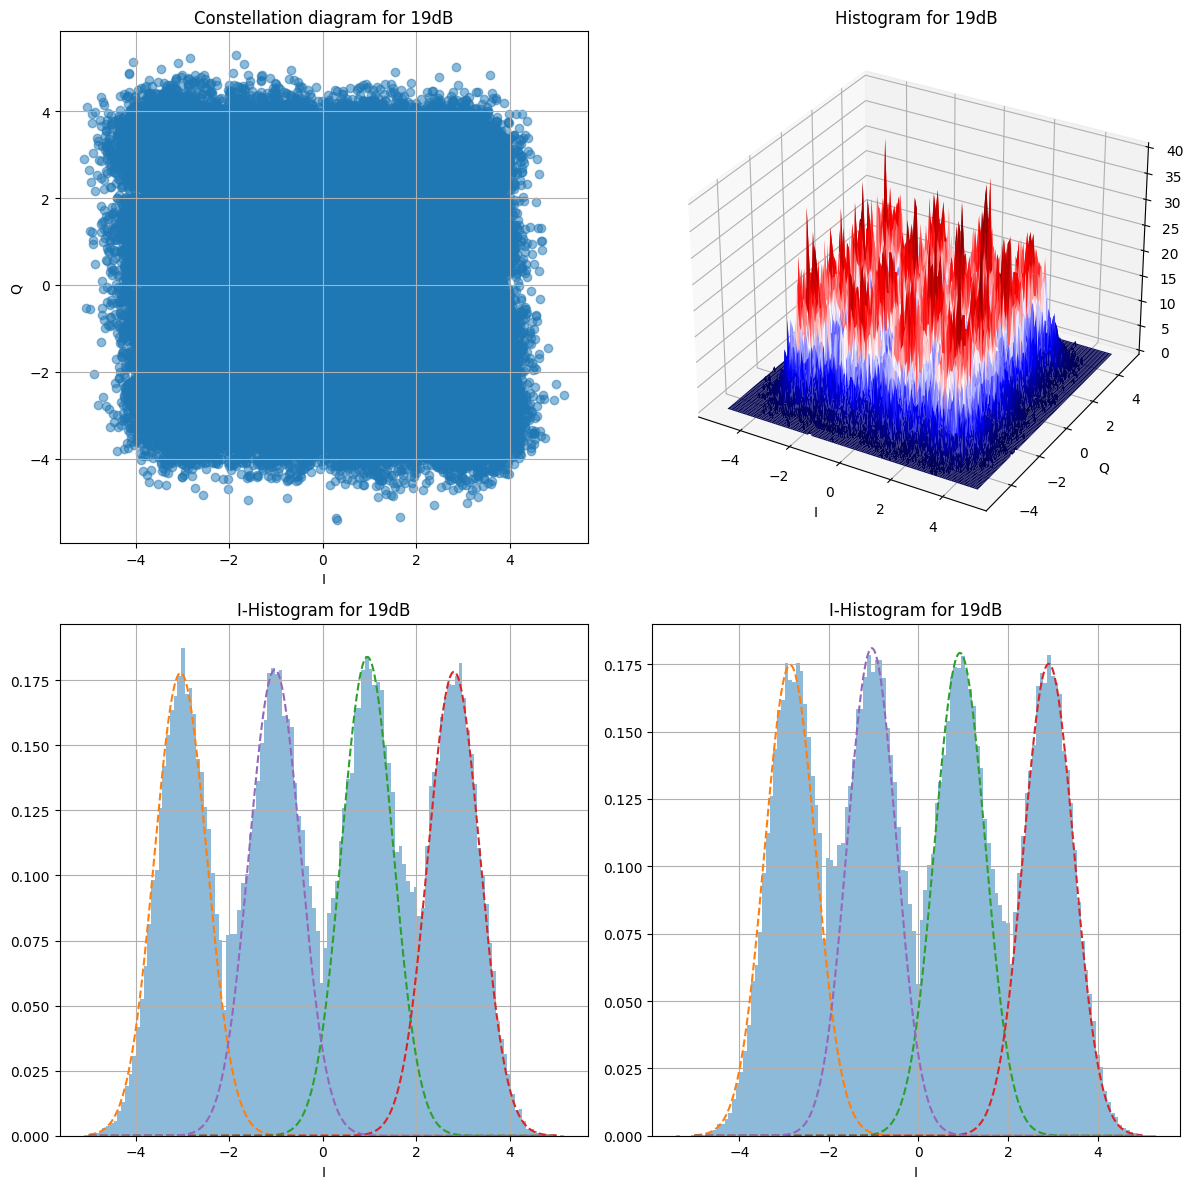

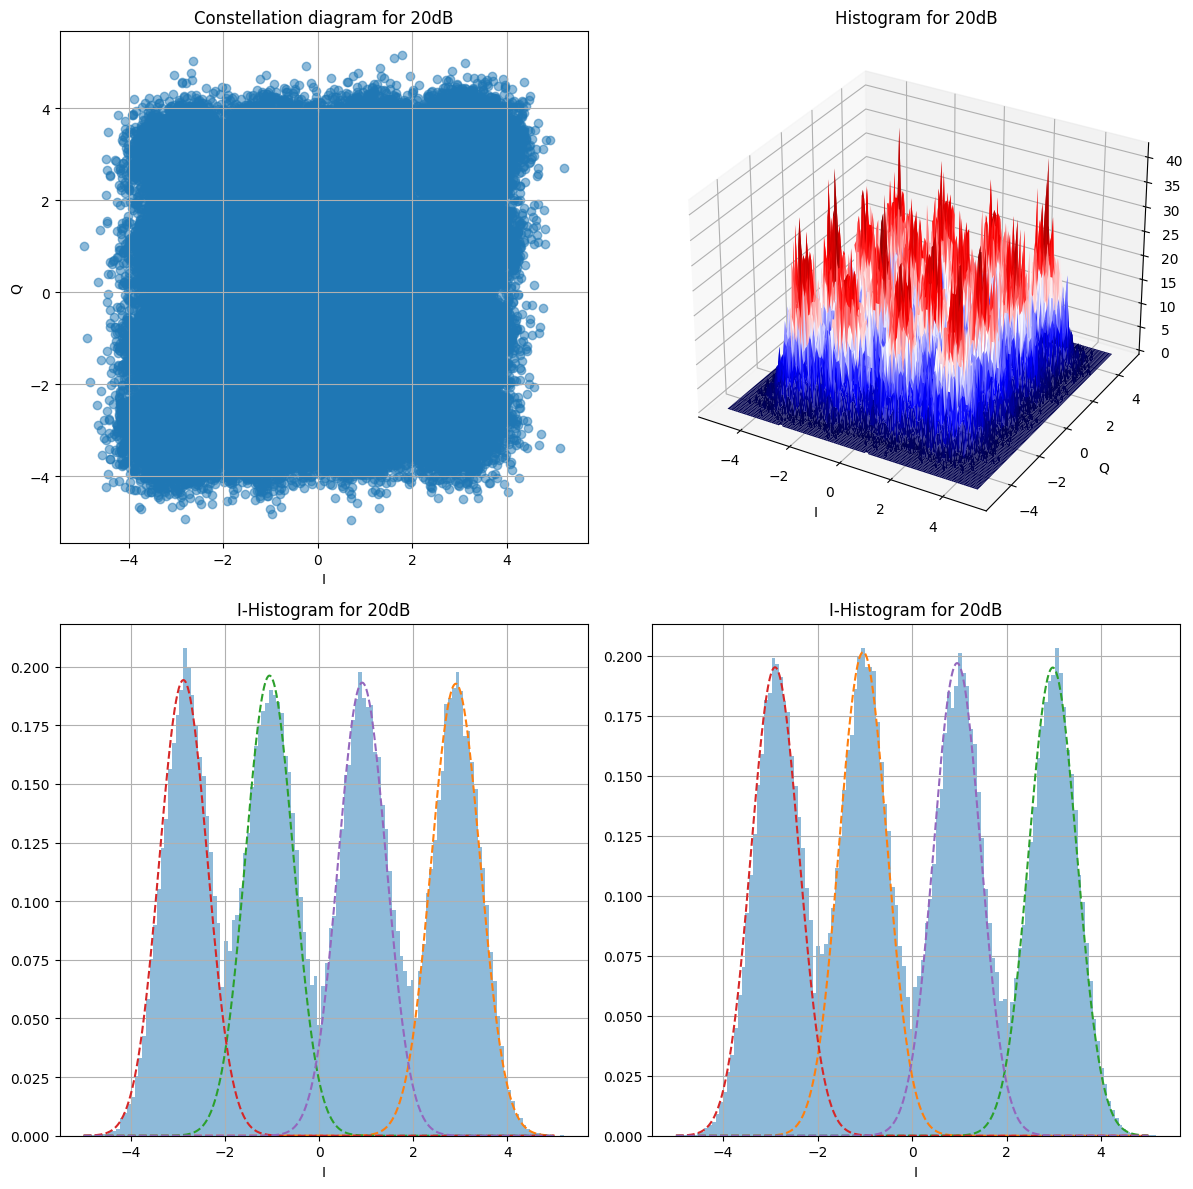

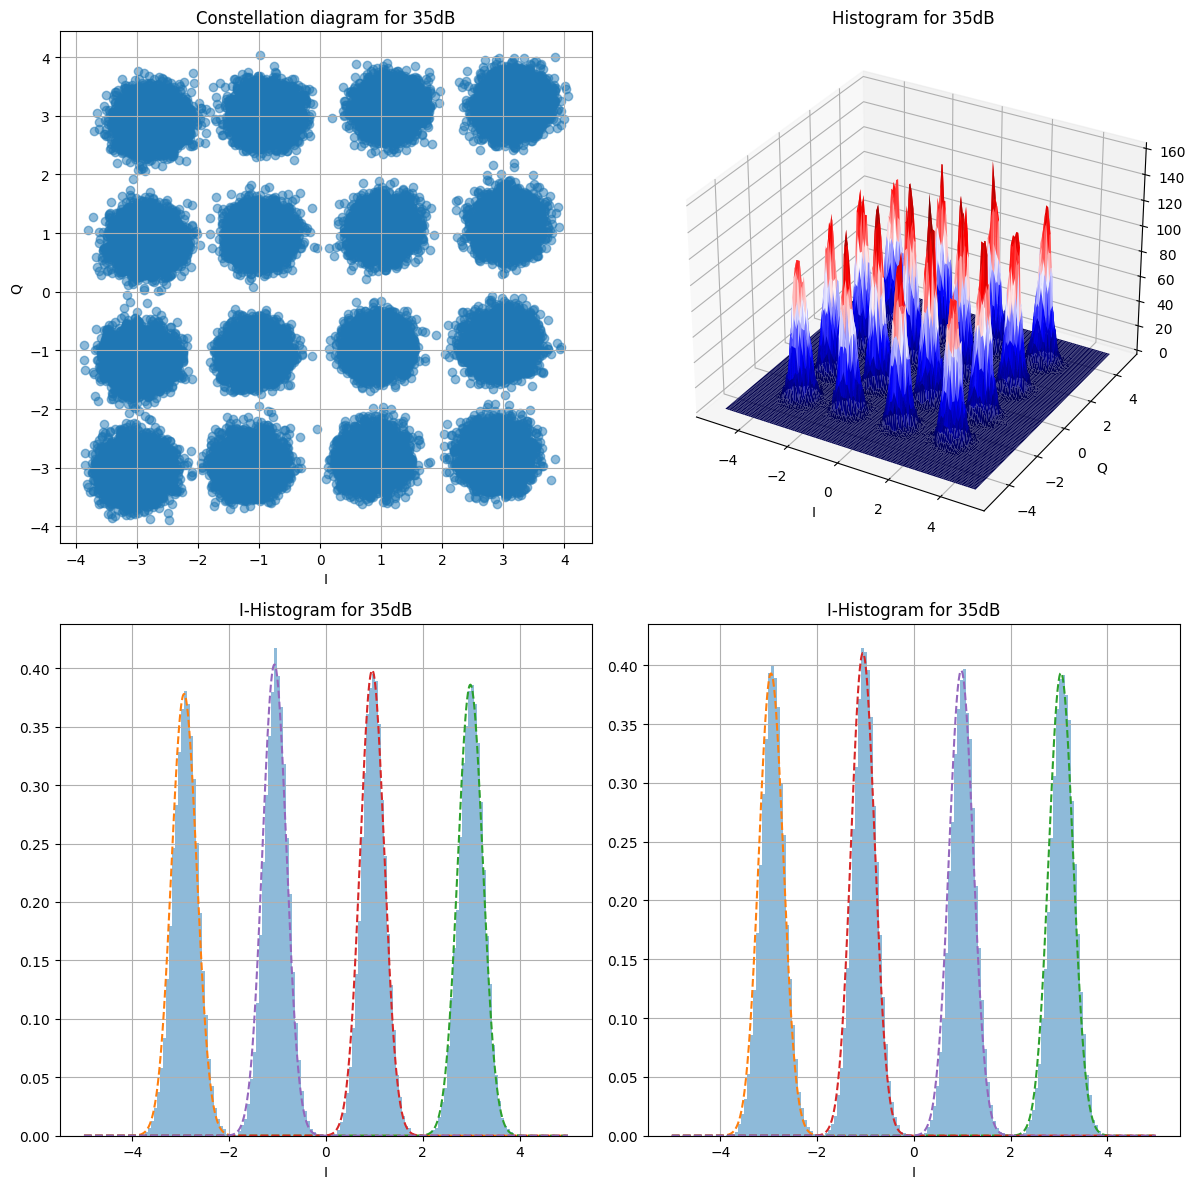

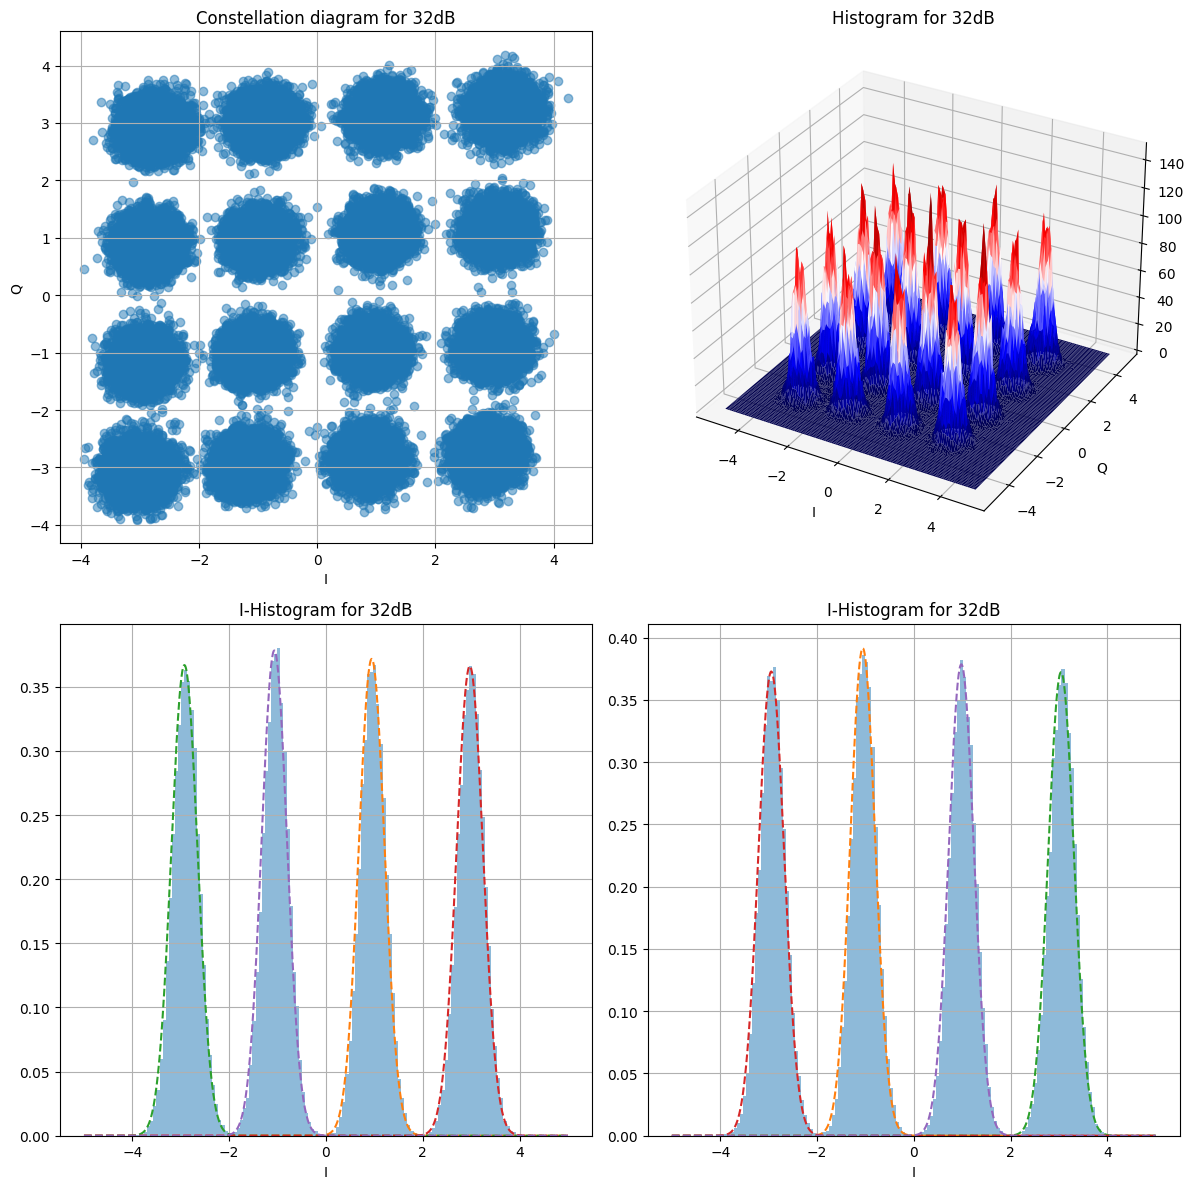

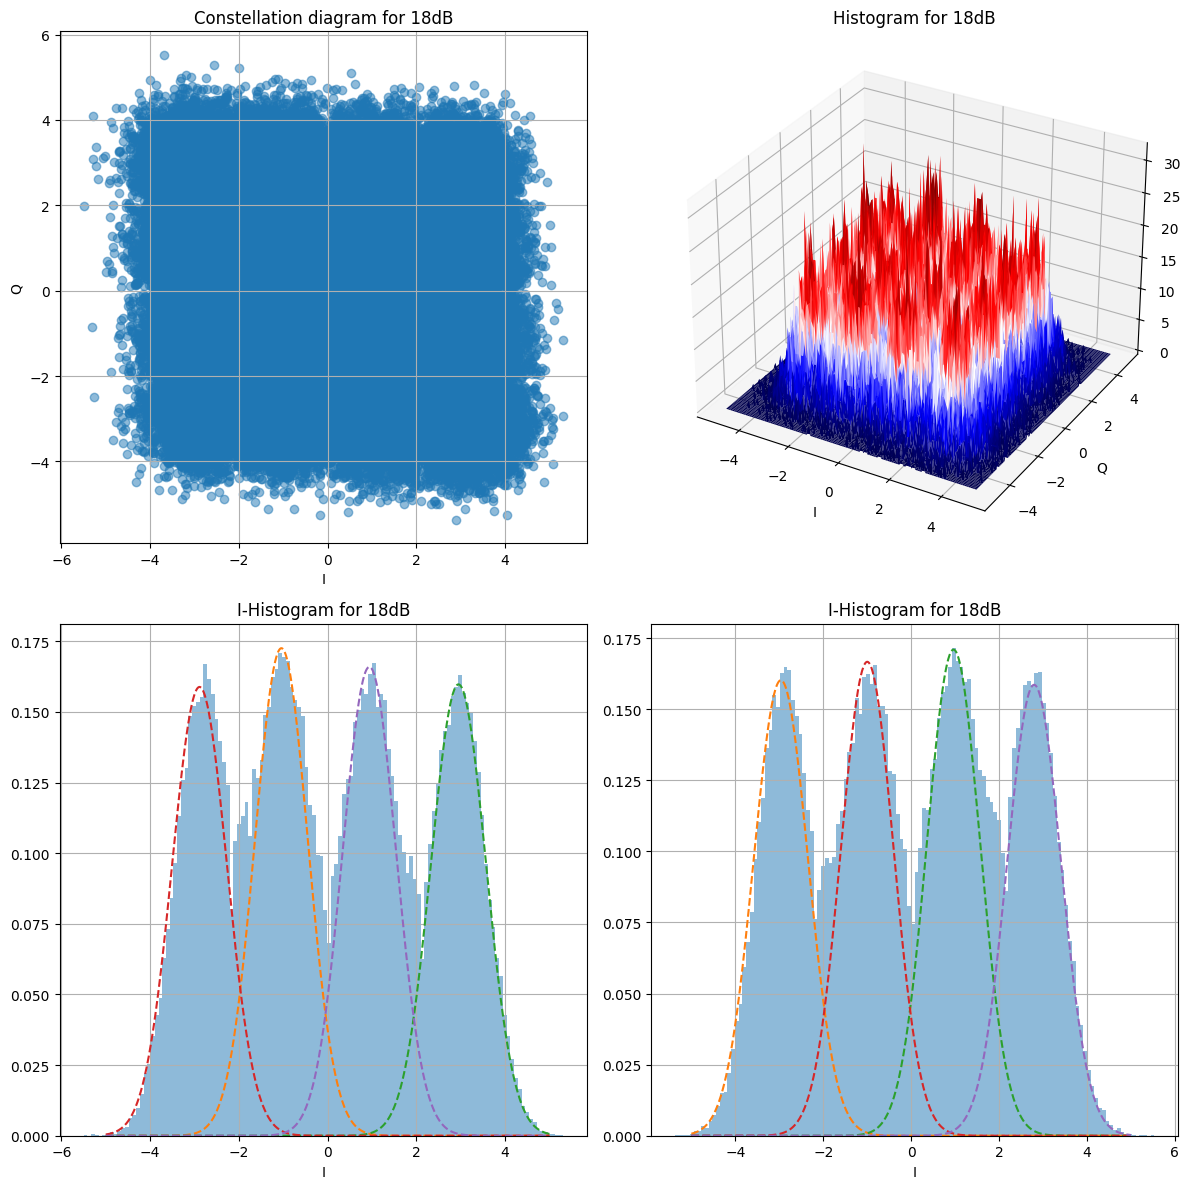

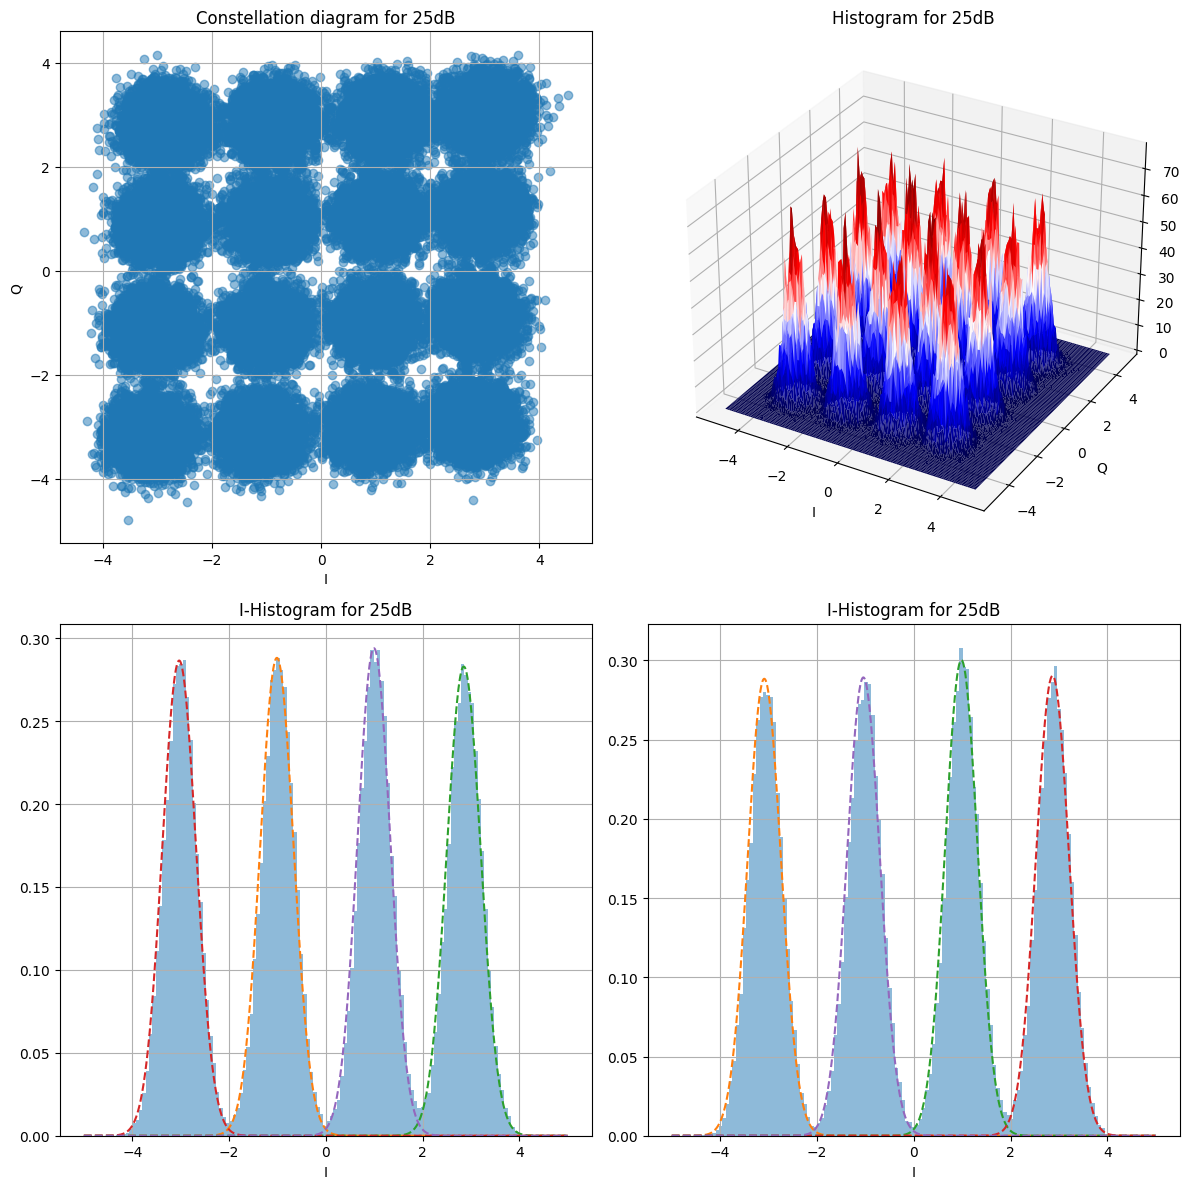

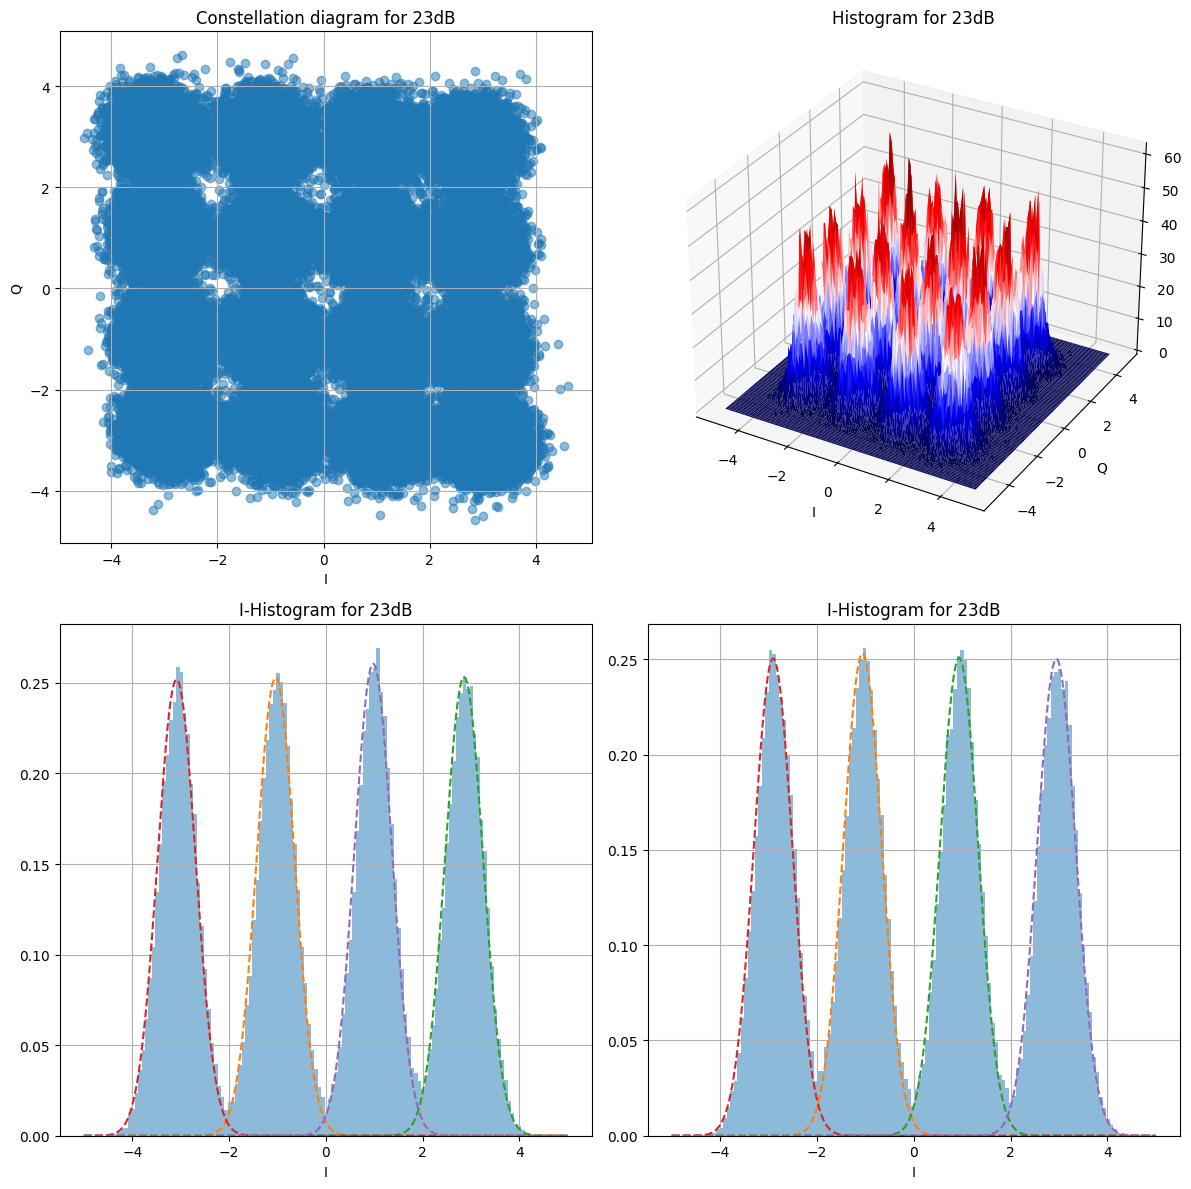

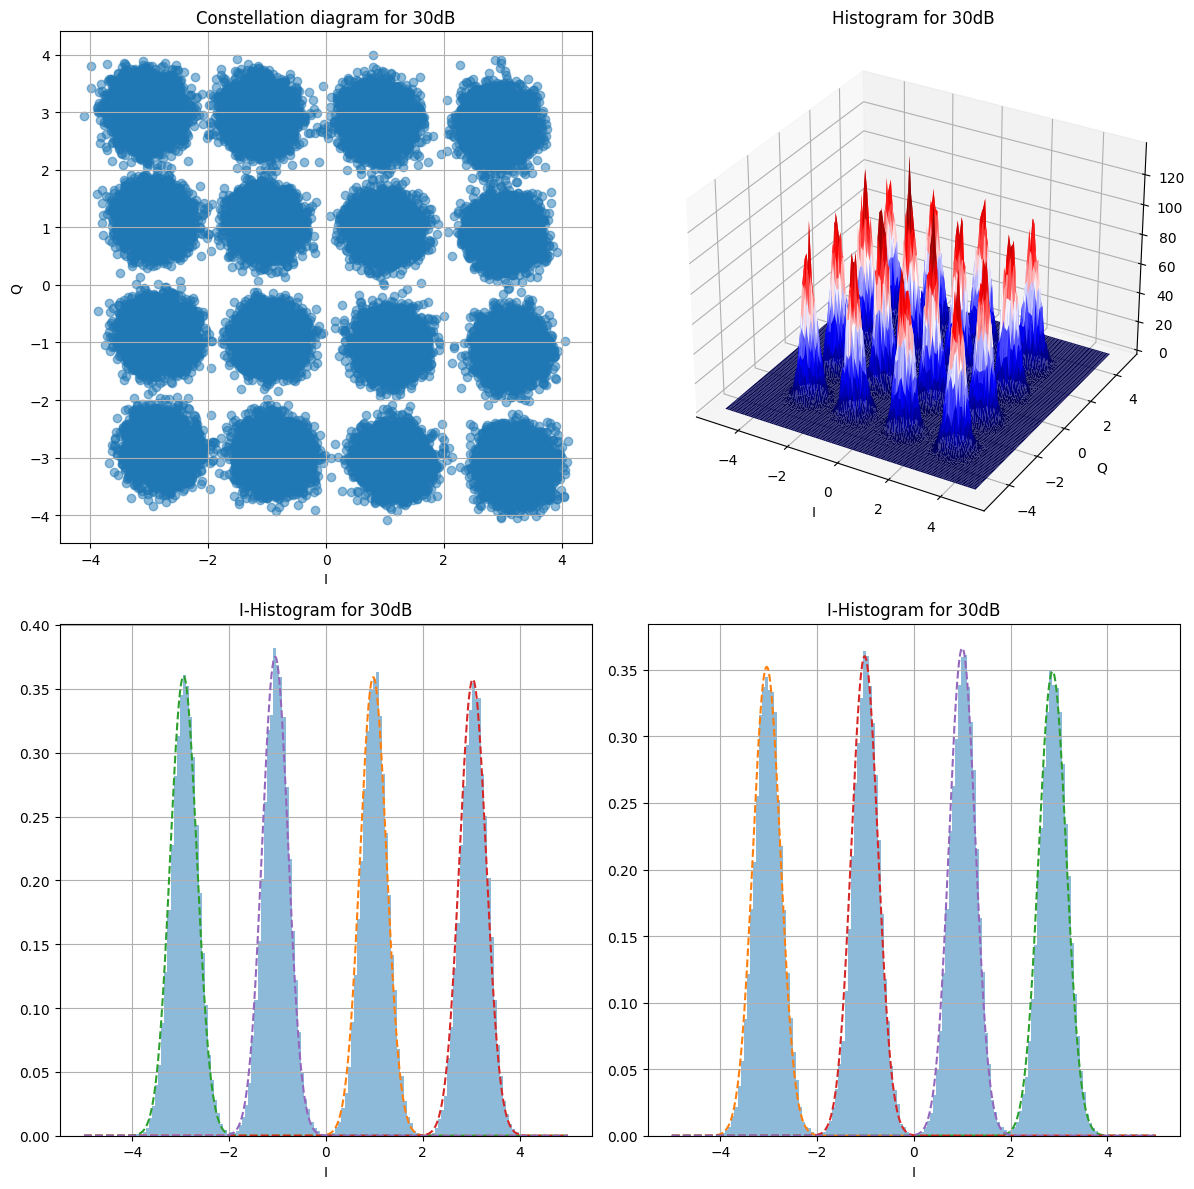

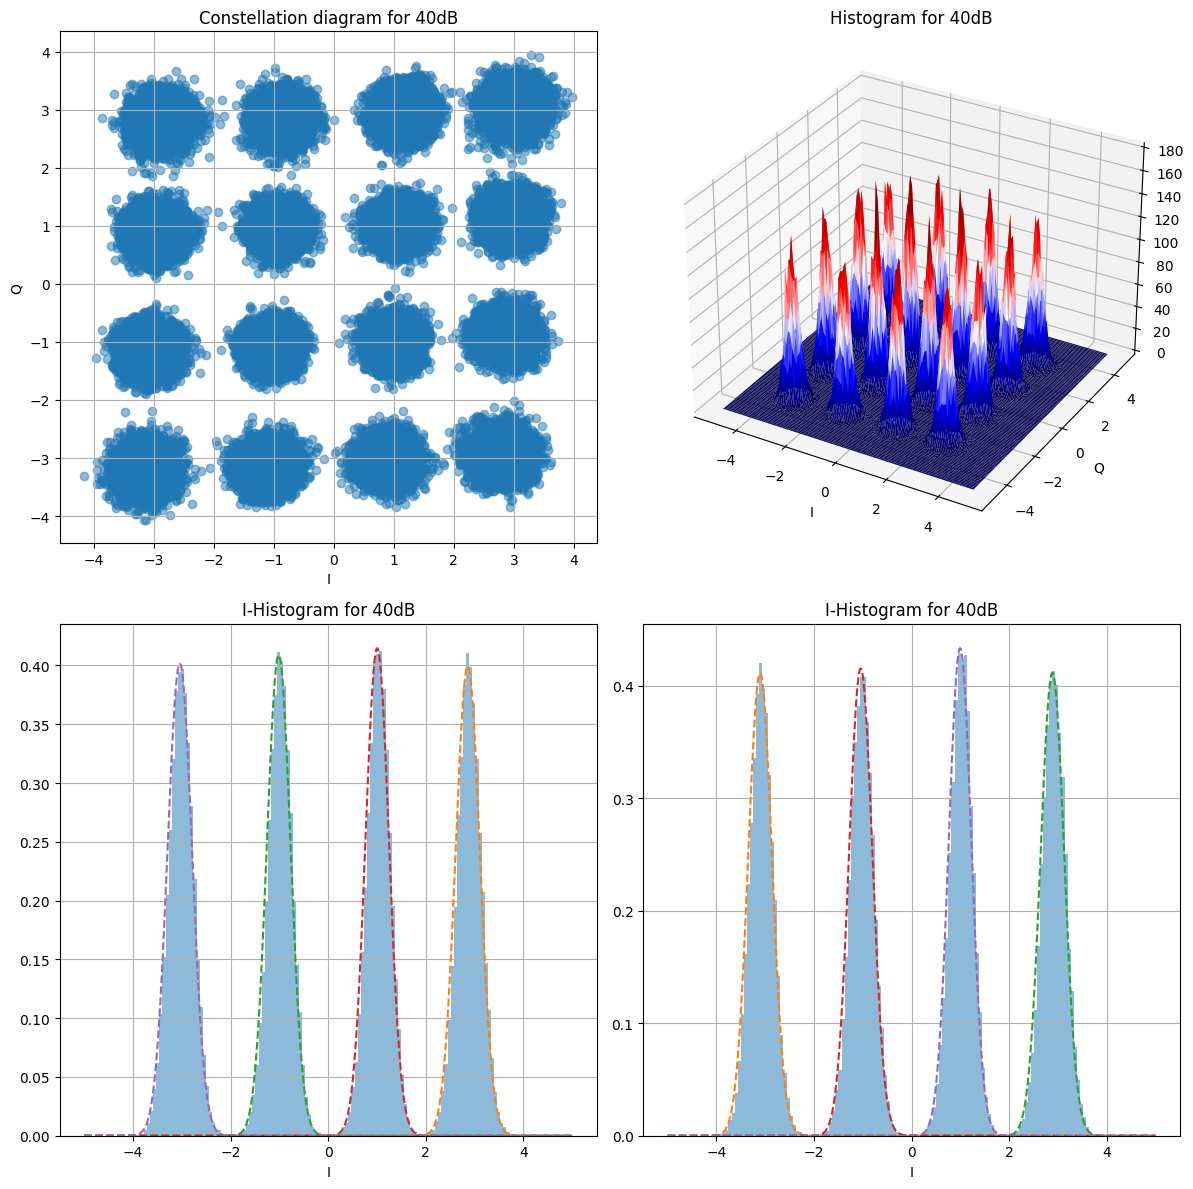

In [4]:
spacing = "18"
X_rx = data[f"{spacing}GHz_spacing"]

histograms = {}
gaussians = {}
bins = 128
limits = [-5, 5]

for i, snr in enumerate(X_rx):
    # Extract data 
    X_ch_norm = X_rx[snr].get("const_Y").flatten()
    X_ch = sofa.mod_norm(X_ch_norm, 10)*X_ch_norm
    
    plt.figure(figsize=(12, 12), layout="tight")
    
    # Plot constellation diagram
    plt.subplot(2, 2, 1)
    plot_constellation_diagram(X_ch, snr)
    
    # Plot 3D histogram
    ax = plt.subplot(2, 2, 2, projection="3d")
    histograms = plot_3d_histogram(X_ch, bins, limits, spacing, snr, ax, histograms)

    # Plot I and Q histograms separately
    # I
    ax = plt.subplot(2, 2, 3)
    plot_histogram_and_gmm(X_ch.real, bins, limits, ax, gaussians)
    plt.title(f"I-Histogram for {snr[5:]}")
    plt.xlabel("I")
    
    # Q
    ax = plt.subplot(2, 2, 4)
    plot_histogram_and_gmm(X_ch.imag, bins, limits, ax, gaussians)
    plt.title(f"I-Histogram for {snr[5:]}")
    plt.xlabel("I")
    
    
    plt.show()

In [5]:
gaussians

{'18GHz_spacing': {'27dB': GaussianMixture(n_components=4),
  '19dB': GaussianMixture(n_components=4),
  '20dB': GaussianMixture(n_components=4),
  '35dB': GaussianMixture(n_components=4),
  '32dB': GaussianMixture(n_components=4),
  '18dB': GaussianMixture(n_components=4),
  '25dB': GaussianMixture(n_components=4),
  '23dB': GaussianMixture(n_components=4),
  '30dB': GaussianMixture(n_components=4),
  '40dB': GaussianMixture(n_components=4)}}

In [8]:
gauss = gaussians.get("18GHz_spacing").get("27dB")

In [10]:
gauss.

array([[-2.91513305],
       [ 0.94364233],
       [-1.06459883],
       [ 2.96607595]])